# Data Preprocessing

In [1]:
# import pandas as pd 
# from scipy import stats
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

## Data Cleaning

In [4]:
train_data = pd.read_csv("CleanLoan2.csv", sep = ",")

In [5]:
df = train_data.copy()
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
#Checking missing values
print("Missing Values")
missing_values = df.isnull().sum()
if missing_values.sum()>0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values")

#Checking for duplicates
print("\nDuplicate Rows:")
duplicates = df.duplicated().sum()
print(f"Number of duplicated Rows: {duplicates}")

if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(duplicates))*100:.2f}%")
else:
    print("There are no duplicate rows.")

Missing Values
No missing values

Duplicate Rows:
Number of duplicated Rows: 0
There are no duplicate rows.


In [7]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


## 2. EDA-Based Data Quality Assessment

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [10]:
df_processed = df.copy()

# 1. Checking for missing values
print("\n1. Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum()>0:
    print(missing_values[missing_values>0])
else:
    print("No missing values found (as expected from EDA)")

#2. Checking for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")

#3. Checking for skewness for variable identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanAmountTerm"]
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness >0.5 else 'approximately normal'})")

# #4. Checking for correlation with target (EDA evidence)
# print("\n4. Correlation with Loan_Status (EDA Evidence):")
# num_features = df_processed.select_dtypes(include=['float64', 'int64']).columns
# # num_features = num_features.drop("Credit_History")
# num_features = pd.DataFrame(df_processed[num_features])

# correlations = num_features.corr()["Loan_Status"].sort_values(key=abs, ascending=False)
# high_signal = correlations[abs(correlations)>0.2].drop("Loan_Status")
# for feature, corr in high_signal.items():
#     print(f"{feature}: {corr:.3f}")

# print("\nLow-signal features (|correlation| < 0.1):")
# low_signal = correlations[abs(correlations) < 0.1]
# for feature, corr in low_signal.items():
#     print(f"{feature}: {corr:.3f}")


1. Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 6.524 (right-skewed)
CoapplicantIncome: skewness = 7.473 (right-skewed)
LoanAmount: skewness = 2.736 (right-skewed)


In [11]:
# num_features = df.select_dtypes(include=['float64', 'int64']).columns
# num_features = num_features.drop("Credit_History")
# num_features = pd.DataFrame(df[num_features])
# num_features

In [12]:
df_processed.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

## 3. Handle Duplicates

In [13]:
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("No duplicates to remove (as expected from EDA)")

No duplicates to remove (as expected from EDA)


In [14]:
df_processed.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

## 5. Outlier Treatment (EDA Recommendation)


In [15]:
# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
print("EDA recommended IQR-capping for extreme features to preserve data points")

numerical_cols = df_processed.select_dtypes(include='number').columns
numerical_cols = numerical_cols.drop(["Loan_Amount_Term","Credit_History"])

print(f"Treating outliers in {len(numerical_cols)} numerical features...")
print(numerical_cols)

#Applying IQR-capping method
outliers_capped = 0
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5 * IQR

    #Counting outliers before capping
    outliers_before = ((df_processed[col]< lower_bound)| (df_processed[col] > upper_bound)).sum()
    if outliers_before > 0:
        #Cap outliers
        df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
        df_processed[col] = np.where(df_processed[col]> upper_bound, upper_bound, df_processed[col])
        outliers_capped += outliers_before
        print(f"\n{col}: Capped {outliers_before} outliers")

print(f'\nTotal outliers capped: {outliers_capped}')
print(f"Dataset shape after outlier treatment: {df_processed.shape}")

=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for extreme features to preserve data points
Treating outliers in 3 numerical features...
Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], dtype='object')

ApplicantIncome: Capped 50 outliers

CoapplicantIncome: Capped 18 outliers

LoanAmount: Capped 41 outliers

Total outliers capped: 109
Dataset shape after outlier treatment: (614, 13)


## 4. Log-Transform Skewed Variables (EDA Recommended)

In [16]:
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

#Variables to log-transform based on EDA findings
skewed_vars = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanAmountTerm"]

for var in skewed_vars:
    if var in df_processed.columns:
        #Check if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <= 0:
            #Use log1p for variables with zeros
            df_processed[f"{var}_log"] = np.log1p(df_processed[var])
            print(f"\n{var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
        else:
            #use log for positive values only
            df_processed[f"{var}_log"]= np.log(df_processed[var])
            print(f"\n{var}: Applied log transformation")
        
        #Checking skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f"{var}_log"])
        print(f"Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\n Dataset shape after log transformation: {df_processed.shape}")
print(f"New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])

=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:

ApplicantIncome: Applied log transformation
Original skewness: 1.037 → Transformed skewness: -0.594

CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
Original skewness: 1.010 → Transformed skewness: -0.184

LoanAmount: Applied log transformation
Original skewness: 0.682 → Transformed skewness: -0.937

 Dataset shape after log transformation: (614, 16)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


Bsed on EDA findings, handle outliers using IQR-capping method

## 6. Feature Engineering

In [17]:
df_processed.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    float64
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [19]:

num_col = df_processed.select_dtypes(include=['float64', 'int64']).columns
num_col

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'ApplicantIncome_log',
       'CoapplicantIncome_log', 'LoanAmount_log'],
      dtype='object')

### Encoding

In [20]:
df_processed.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y,8.674026,0.000000,4.85203
1,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N,8.430109,7.319202,4.85203


In [21]:
#Encoding 
le = LabelEncoder()
binary_col = ["Gender", "Married", "Education", "Self_Employed", "Loan_Status"]
for col in binary_col:
    df_processed[col] = le.fit_transform(df_processed[col])

# df[["Gender", "Married", "Education", "Self_Employed"]]
# df.head(2)

ohe = OneHotEncoder(sparse_output=False, drop="first")
df_processed["Property_Area"] = ohe.fit_transform(df[["Property_Area"]])
df_processed.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001002,1,0,0,0,0,5849.0,0.0,128.0,360.0,1.0,0.0,1,8.674026,0.000000,4.85203
1,LP001003,1,1,1,0,0,4583.0,1508.0,128.0,360.0,1.0,0.0,0,8.430109,7.319202,4.85203


In [22]:
df_processed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,LP001002,1,0,0,0,0,5849.0,0.0,128.0,360.0,1.0,0.0,1,8.674026,0.000000,4.852030
1,LP001003,1,1,1,0,0,4583.0,1508.0,128.0,360.0,1.0,0.0,0,8.430109,7.319202,4.852030
2,LP001005,1,1,0,0,1,3000.0,0.0,66.0,360.0,1.0,0.0,1,8.006368,0.000000,4.189655
3,LP001006,1,1,0,1,0,2583.0,2358.0,120.0,360.0,1.0,0.0,1,7.856707,7.765993,4.787492
4,LP001008,1,0,0,0,0,6000.0,0.0,141.0,360.0,1.0,0.0,1,8.699515,0.000000,4.948760


In [23]:
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")


#Total loan applicant income
df_processed["Total_Income"] = df_processed["ApplicantIncome"] + df_processed["CoapplicantIncome"]

#Loan to income ratio
df_processed["Loan_Income_Ratio"] = df_processed["LoanAmount"]/df_processed["Total_Income"]

#Estimated monthly payment plan
df_processed["Monthly_Payment"] = df_processed["LoanAmount"]/df_processed["Loan_Amount_Term"]



#Splitting income into bins
df_processed["Income_Category"] = pd.qcut(df_processed["ApplicantIncome"], 3, labels=False)

df_processed[["Total_Income", "LoanAmount","Loan_Income_Ratio", "Monthly_Payment", "Income_Category"]].head()

FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS


,Total_Income,LoanAmount,Loan_Income_Ratio,Monthly_Payment,Income_Category
0,5849.0,128.0,0.021884,0.355556,2
1,6091.0,128.0,0.021015,0.355556,1
2,3000.0,66.0,0.022000,0.183333,0
3,4941.0,120.0,0.024287,0.333333,0
4,6000.0,141.0,0.023500,0.391667,2


## Feature Scaling

In [24]:
# #Scaling
scaler = StandardScaler()
df_processed[num_col] = scaler.fit_transform(df_processed[num_col])
print(df_processed[num_col].std())

ApplicantIncome          1.000815
CoapplicantIncome        1.000815
LoanAmount               1.000815
Loan_Amount_Term         1.000815
Credit_History           1.000815
ApplicantIncome_log      1.000815
CoapplicantIncome_log    1.000815
LoanAmount_log           1.000815
dtype: float64


In [25]:
df_processed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income,Loan_Income_Ratio,Monthly_Payment,Income_Category
0,LP001002,1,0,0,0,0,0.497164,-0.874587,-0.168041,0.273231,0.411733,0.0,1,0.689242,-1.109654,0.041128,5849.0,0.021884,0.355556,2
1,LP001003,1,1,1,0,0,-0.013767,0.054395,-0.168041,0.273231,0.411733,0.0,0,0.241777,0.791149,0.041128,6091.0,0.021015,0.355556,1
2,LP001005,1,1,0,0,1,-0.652632,-0.874587,-1.280462,0.273231,0.411733,0.0,1,-0.535577,-1.109654,-1.446177,3000.0,0.022000,0.183333,0
3,LP001006,1,1,0,1,0,-0.820924,0.578025,-0.311579,0.273231,0.411733,0.0,1,-0.810129,0.907181,-0.103788,4941.0,0.024287,0.333333,0
4,LP001008,1,0,0,0,0,0.558104,-0.874587,0.065209,0.273231,0.411733,0.0,1,0.736001,-1.109654,0.258326,6000.0,0.023500,0.391667,2


## 7. Feature Selection


In [26]:
# Feature selection based on EDA correlation evidence
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

X = df_processed.drop(columns=["Loan_Status", "Loan_ID"], axis=1)
y = df_processed["Loan_Status"]

print(f"Total features available: {X.shape[1]}")

#EDA identified high-signal features (|correlation|>0.2)
high_signal_features = ["Credit_History"]
print(f"\nEDA-identified high-signal features: {high_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1) 
low_signal_features = ["CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "ApplicantIncome"]
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are actually available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# Create feature sets for evaluation
print("\n=== FEATURE SETS FOR EVALUATION ===")

#Set1: All original features (excluding low signal)
features_exclude_low_signal = [col for col in X.columns if col not  in low_signal_features]
print(f"Set 1 - Exclude low-signal features; {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = available_high_signal + [col for col in X.columns if any(keyword in col.lower() for keyword in ["total", "ratio", "monthly", "log"])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

#Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

#Using high signal features and engineered features as recommended by the EDA
selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)



=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 18

EDA-identified high-signal features: ['Credit_History']
EDA-identified low-signal features: ['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome']

Available high-signal features: ['Credit_History']
Available low-signal features: ['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome']

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Exclude low-signal features; 14 features
Set 2 - High-signal + engineered: 7 features
Set 3 - All features: 18 features

✓ Selected feature set: 7 features
Selected features: ['Credit_History', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio', 'Monthly_Payment']


## 8. Data Splitting (Stratified)

In [27]:
#Stratified data splitting based on EDA findsings about class imbalance
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

#Select chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

#First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y,  test_size=0.2, random_state=42, stratify=y
)

#Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify = y_temp
)
print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f})%")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f})%")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f})%")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())

print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())

print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())


=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (614, 7)

Data split results:
Training set: (368, 7) (59.9)%
Validation set: (123, 7) (20.0)%
Test set: (123, 7) (20.0)%

Class distribution verification:
Training set quality distribution:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set quality distribution:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set quality distribution:
Loan_Status
0    38
1    85
Name: count, dtype: int64


## 9. Feature Scaling

In [28]:
# #Applying StandardScaler as recommended by EDA
# print("=== FEATURE SCALING (STANDARD SCALER) ===")
# print("EDA recommended StandardScaler for distance-based models")

# #Fitting scaler on training data only (to avoid data leakage)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# #Transforming validation and test sets
# X_val_scaled = scaler.transform(X_val)
# X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# X_test_scaled = scaler.transform(X_test)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# print("✓ Scaling applied successfully!")
# print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
# print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
# print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

# #Verigy scaling worked correctly
# print(f"\nScaling verification")
# print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean())< 0.01}")
# print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean()-1) < 0.01}")
# print(f"{abs(X_train_scaled.std().mean())}")

## 10. Feature Importance Analysis

In [29]:
# # Feature importance analysis to validate EDA-based engineering
# print("=== FEATURE IMPORTANCE ANALYSIS ===")

# # Calculate correlation with target for all features
# feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

# print("Top 10 features by correlation with quality:")
# for i, (feature, corr) in enumerate(feature_correlations.head(10).items(),1):
#     print(f"{i:2d}. {feature}: {corr:.3f}")

# # Check if engineered features are among top features
# engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ["total", "ratio", "monthly", "log"])]
# print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# #Visualize feature importance
# plt.figure(figsize=(12,8))
# top_features = feature_correlations.head(15)
# colors = ['red' if any(keyword in f.lower() for keyword in ["total", "ratio", "monthly", "log"])else 'blue' for f in top_features.index]

# plt.barh(range(len(top_features)), top_features.values, color=colors)
# plt.yticks(range(len(top_features)), top_features.index)
# plt.xlabel("Absolute Correlation with Quality")
# plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

# print(f"\n✓ Feature importance analysis completed")
# print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. Credit_History: 0.510
 2. Loan_Income_Ratio: 0.066
 3. Monthly_Payment: 0.061
 4. CoapplicantIncome_log: 0.048
 5. LoanAmount_log: 0.025
 6. ApplicantIncome_log: 0.017
 7. Total_Income: 0.014

Engineered features in top 10: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio', 'Monthly_Payment']


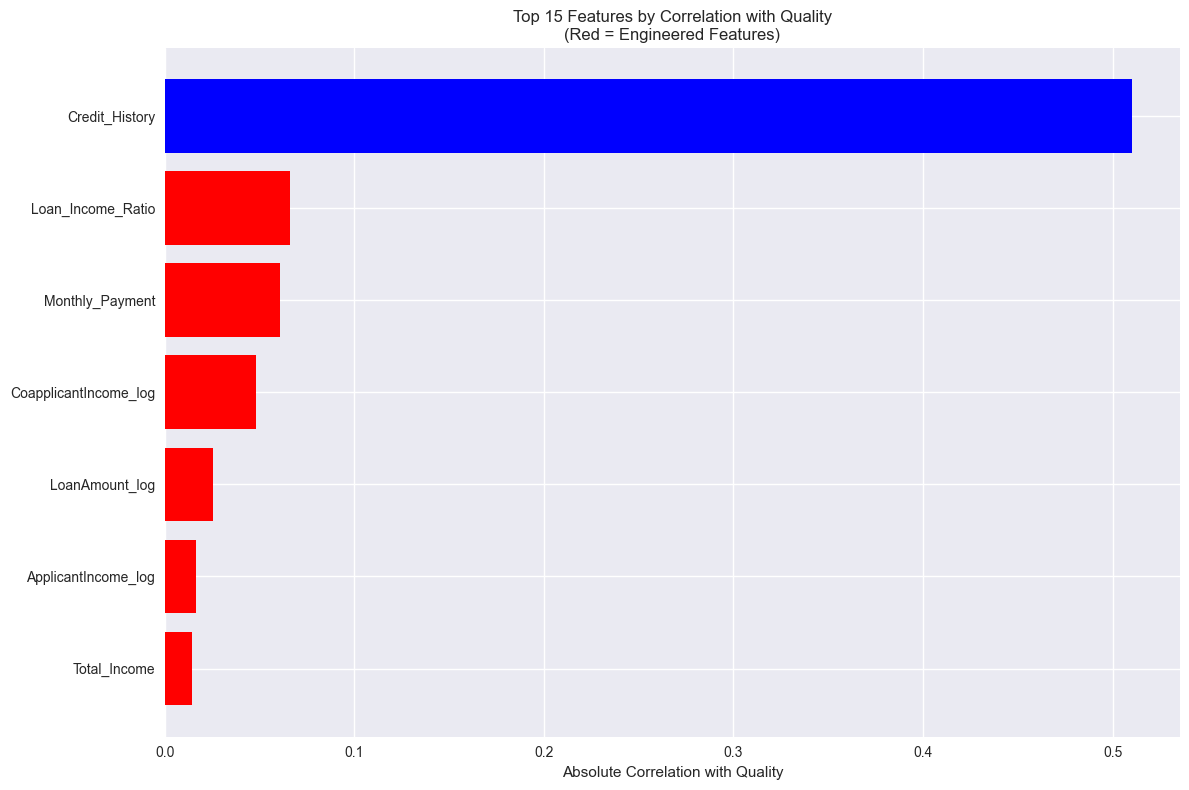


✓ Feature importance analysis completed
✓ 6 engineered features in top 10


In [30]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(),1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train.columns if any(keyword in col.lower() for keyword in ["total", "ratio", "monthly", "log"])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

#Visualize feature importance
plt.figure(figsize=(12,8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ["total", "ratio", "monthly", "log"])else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel("Absolute Correlation with Quality")
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


## 11. Save Preprocessed Data

In [31]:
# print("SAVING PREPROCESSED DATA ")

# # Save scaled datasets
# X_train_scaled.to_csv("X_train_scaled.csv", index=False)
# X_val_scaled.to_csv("X_val_scaled.csv", index=False)
# X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# # Save target variables
# y_train.to_csv('y_train.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

# #Save preprocessing objects
# import joblib
# joblib.dump(scaler, 'scaler.pkl')
# joblib.dump(selected_features, 'selected_features.pkl')

# #Save feature importance
# feature_importance_df = pd.DataFrame({
#     "feature": feature_correlations.index,
#     "correlation": feature_correlations.values
# })
# feature_importance_df.to_csv("feature_importance.csv", index=False)

# # Save preprocessing summary
# preprocessing_summary = {
#     'original_shape': df.shape,
#     'final_shape': df_processed.shape,
#     'selected_features': selected_features,
#     'engineered_features': engineered_features,
#     'train_samples': X_train_scaled.shape[0],
#     'val_samples': X_val_scaled.shape[0],
#     'test_samples': X_test_scaled.shape[0],
#     'scaling_method': 'StandardScaler',
#     'outlier_treatment': 'IQR_capping',
#     'log_transformed': ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanAmountTerm"]
# }

# import json
# with open('preprocessing_summary.json', 'w') as f:
#     json.dump(preprocessing_summary, f, indent=2)

# print("- Preprocessed data saved successfully!")
# print("\nFiles created:")
# print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
# print("- y_train.csv, y_val.csv, y_test.csv")
# print("- scaler.pkl, selected_features.pkl")
# print("- feature_importance.csv, preprocessing_summary.json")


In [32]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train.to_csv("X_train_scaled.csv", index=False)
X_val.to_csv("X_val_scaled.csv", index=False)
X_test.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

#Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

#Save feature importance
feature_importance_df = pd.DataFrame({
    "feature": feature_correlations.index,
    "correlation": feature_correlations.values
})
feature_importance_df.to_csv("feature_importance.csv", index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train.shape[0],
    'val_samples': X_val.shape[0],
    'test_samples': X_test.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanAmountTerm"]
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 


- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


## 12. Preprocessing Summary

In [33]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, duplicates handled)")
print("> Log-transformation of skewed variables (ApplicantIncome, CoapplicantIncome, LoanAmount, LoanAmountTerm")
print("> Outlier treatment using IQR-capping method")
print("> Feature engineering based on EDA recommendations:")
print("> Total_Income (ApplicantIncome + CoapplicantIncome)")
print(">Loan_Income_Ratio (LoanAmount/Total_Income)")
print(">Monthy_Payment (LoanAmount/Loan_Amount_Term")

print("> Feature selection (high-signal features + engineered features)")
print("> Stratified data splitting (preserves class distribution)")
print("> StandardScaler applied (EDA recommendation for distance-based models)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> High-signal features prioritized: credit_history")
print("> Low-signal features excluded: residual sugar, free sulfur dioxide")
print("> Skewed variables log-transformed as recommended")
print("> Acidity ratios created based on grouped means analysis")
print("> Alcohol-acidity interactions based on trivariate analysis")
print("> Fermentation efficiency features based on density-alcohol relationship")


print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")

.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (614, 13)
Final processed dataset shape: (614, 20)
Selected features: 7
Training samples: 368
Validation samples: 123
Test samples: 123

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, duplicates handled)
> Log-transformation of skewed variables (ApplicantIncome, CoapplicantIncome, LoanAmount, LoanAmountTerm
> Outlier treatment using IQR-capping method
> Feature engineering based on EDA recommendations:
> Total_Income (ApplicantIncome + CoapplicantIncome)
>Loan_Income_Ratio (LoanAmount/Total_Income)
>Monthy_Payment (LoanAmount/Loan_Amount_Term
> Feature selection (high-signal features + engineered features)
> Stratified data splitting (preserves class distribution)
> StandardScaler applied (EDA recommendation for distance-based models)
> Feature importance analysis (validates engineered features)
> Data export (ready for modeling)

.....EDA EVIDENCE IMPLEMENTE